In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [ ]:
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
#read the file
df = pd.read_csv('PSA TRAIN-1.csv')

In [ ]:
df.head()

,Time,Bed Pressure
0,0,16.650
1,1,16.745
2,2,16.840
3,3,16.935
4,4,17.029


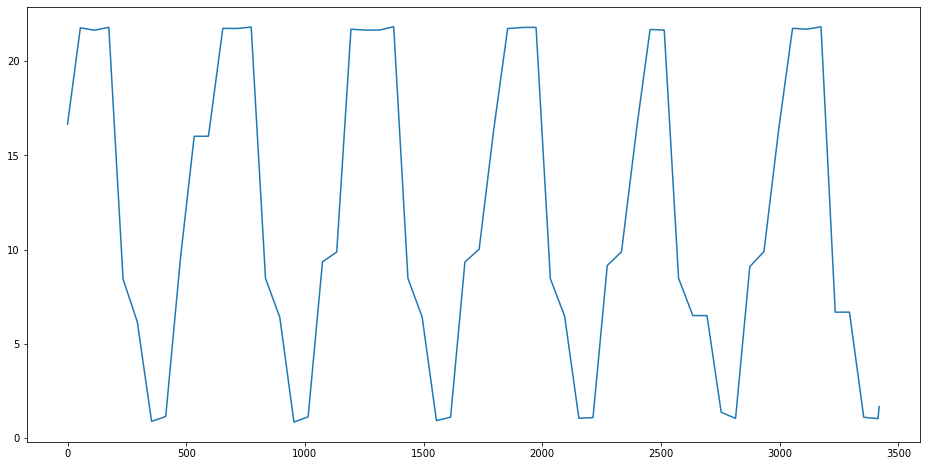

In [ ]:
df.index = df['Time']
plt.figure(figsize=(16,8))
plt.plot(df['Bed Pressure'], label='Bed pressure history')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [ ]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Time', 'Bed Pressure'])
for i in range(0,len(data)):
    new_data['Time'][i] = data['Time'][i]
    new_data['Bed Pressure'][i] = data['Bed Pressure'][i]

In [ ]:
#setting index
new_data.index = new_data.Time
new_data.drop('Time', axis=1, inplace=True)

In [ ]:
#creating train and test sets
dataset = new_data.values

In [ ]:
train = dataset[0:3000,:]
valid = dataset[3000:,:]

In [ ]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

2940/2940 - 71s - loss: 0.0013


In [ ]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
Bed_Pressure = model.predict(X_test)
Bed_Pressure = scaler.inverse_transform(Bed_Pressure)

In [ ]:
rms=np.sqrt(np.mean(np.power((valid-Bed_Pressure),2)))
rms

0.24826593846877673

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


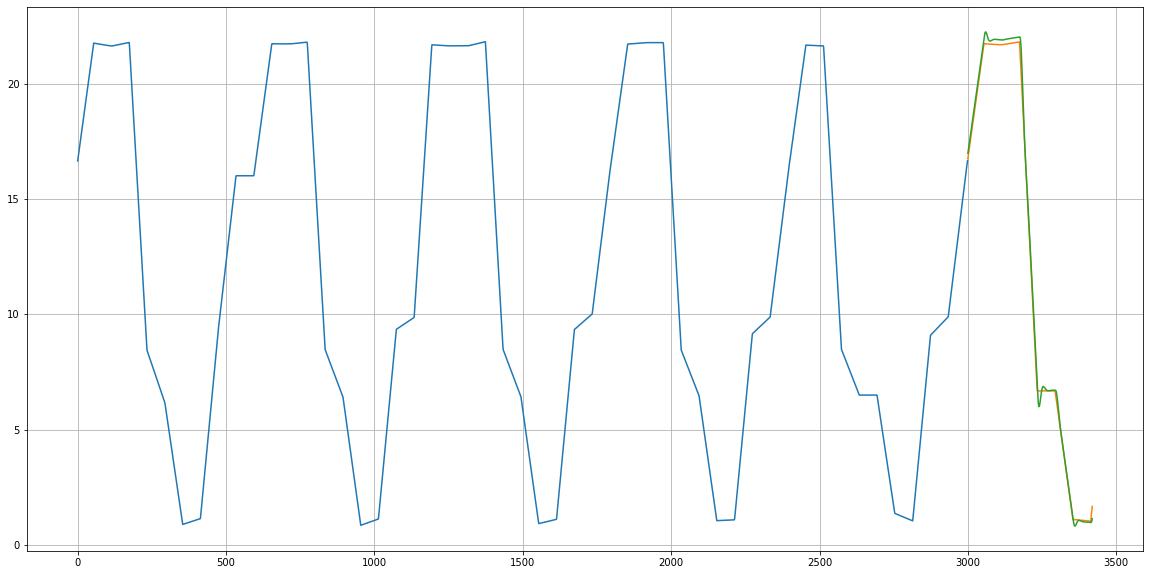

In [ ]:
#for plotting
train = new_data[:3000]
valid = new_data[3000:]
valid['Predictions'] = Bed_Pressure
plt.plot(train['Bed Pressure'])
plt.plot(valid[['Bed Pressure','Predictions']])
plt.grid()